In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')
full_df = pd.read_csv('/content/drive/My Drive/1.0-communities.csv')

Mounted at /content/drive


<ipython-input-3-f2e6780cddef>:2: DtypeWarning: Columns (18,26,70,72,85,131) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv('/content/drive/My Drive/1.0-communities.csv')


In [ ]:
df = full_df[full_df["State/Territory"] == "California"]

unique_counties = sorted(list(set(df['County Name'])))
num_to_county = {i : unique_counties[i] for i in range(len(unique_counties))}
county_to_num = {unique_counties[i] : i for i in range(len(unique_counties))}

print(num_to_county)
print(county_to_num)
print(df.head())

{0: 'Alameda County', 1: 'Alpine County', 2: 'Amador County', 3: 'Butte County', 4: 'Calaveras County', 5: 'Colusa County', 6: 'Contra Costa County', 7: 'Del Norte County', 8: 'El Dorado County', 9: 'Fresno County', 10: 'Glenn County', 11: 'Humboldt County', 12: 'Imperial County', 13: 'Inyo County', 14: 'Kern County', 15: 'Kings County', 16: 'Lake County', 17: 'Lassen County', 18: 'Los Angeles County', 19: 'Madera County', 20: 'Marin County', 21: 'Mariposa County', 22: 'Mendocino County', 23: 'Merced County', 24: 'Modoc County', 25: 'Mono County', 26: 'Monterey County', 27: 'Napa County', 28: 'Nevada County', 29: 'Orange County', 30: 'Placer County', 31: 'Plumas County', 32: 'Riverside County', 33: 'Sacramento County', 34: 'San Benito County', 35: 'San Bernardino County', 36: 'San Diego County', 37: 'San Francisco County', 38: 'San Joaquin County', 39: 'San Luis Obispo County', 40: 'San Mateo County', 41: 'Santa Barbara County', 42: 'Santa Clara County', 43: 'Santa Cruz County', 44: 'S

In [ ]:
df['State/Territory'] = LabelEncoder().fit_transform(df['State/Territory'])
df['Is low income?'] = LabelEncoder().fit_transform(df['Is low income?'])

train_columns = ["Percent White", "Percent Black or African American alone", "Percent Asian", "Percent Hispanic or Latino",
                 "State/Territory", "Percent age over 64", "Is low income?", "Unemployment (percent) (percentile)", "Percent individuals age 25 or over with less than high school degree (percentile)"]

true_columns = ["Low life expectancy (percentile)","Expected building loss rate (Natural Hazards Risk Index) (percentile)",
             "Share of properties at risk of flood in 30 years (percentile)", "Share of properties at risk of fire in 30 years (percentile)",
             "Traffic proximity and volume (percentile)", "PM2.5 in the air (percentile)", "Wastewater discharge (percentile)"]
print(len(df))
df = df.dropna(subset = train_columns + true_columns)
df = df[(df[true_columns] != 0).all(axis=1)]

print(len(df))
train_data = df[train_columns].copy()
true_data = df[true_columns].copy()

print(len(train_data))
print(len(true_data))
# print(train_data.head())
# print(true_data.head())

3736
3736
3736
3736


In [ ]:
train_train, train_val, true_train, true_val = train_test_split(train_data, true_data, test_size=0.2, random_state=1)

train_train_tensor = torch.tensor(train_train.values, dtype=torch.float32)
train_val_tensor = torch.tensor(train_val.values, dtype=torch.float32)
true_train_tensor = torch.tensor(true_train.values, dtype=torch.float32)
true_val_tensor = torch.tensor(true_val.values, dtype=torch.float32)

train_loader = DataLoader(list(zip(train_train_tensor, true_train_tensor)), batch_size=12, shuffle=True)
val_loader = DataLoader(list(zip(train_val_tensor, true_val_tensor)), batch_size=12, shuffle=True)

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Linear(9, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 7),
        )
    def forward(self, x):
        return self.convs(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self.forward(x)

Epoch [1/100], Train Loss: 4152.6592, Validation Loss: 4124.0415
Epoch [2/100], Train Loss: 4112.6265, Validation Loss: 3992.3079
Epoch [3/100], Train Loss: 3983.0286, Validation Loss: 3747.3735
Epoch [4/100], Train Loss: 3740.9592, Validation Loss: 3273.8013
Epoch [5/100], Train Loss: 3271.6382, Validation Loss: 2489.6443
Epoch [6/100], Train Loss: 2493.5098, Validation Loss: 1623.6952
Epoch [7/100], Train Loss: 1633.6044, Validation Loss: 1945.9729
Epoch [8/100], Train Loss: 1950.5015, Validation Loss: 1854.1400
Epoch [9/100], Train Loss: 1856.1407, Validation Loss: 1309.6674
Epoch [10/100], Train Loss: 1313.7339, Validation Loss: 1179.6780
Epoch [11/100], Train Loss: 1183.3771, Validation Loss: 1293.4681
Epoch [12/100], Train Loss: 1295.2516, Validation Loss: 1379.0765
Epoch [13/100], Train Loss: 1379.0774, Validation Loss: 1357.8499
Epoch [14/100], Train Loss: 1356.6088, Validation Loss: 1264.9141
Epoch [15/100], Train Loss: 1262.6771, Validation Loss: 1193.2192
Epoch [16/100], Tra

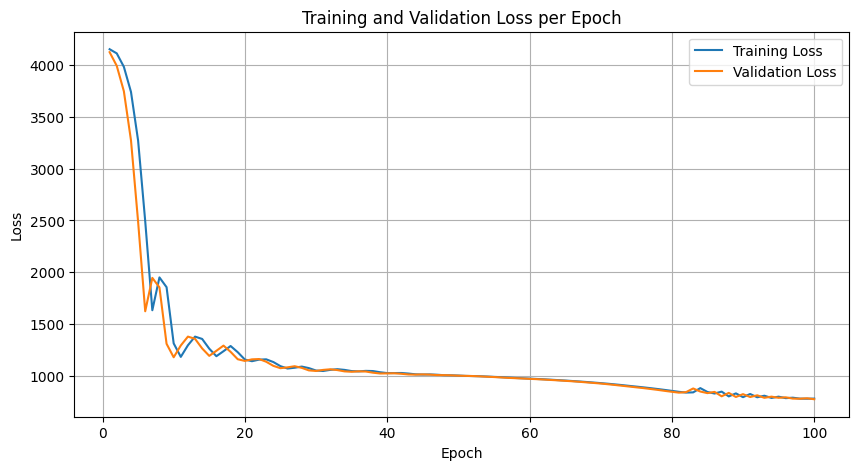

In [ ]:
model = NN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.012)

train_losses = []
val_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(train_train_tensor)
    train_loss = criterion(outputs, true_train_tensor)
    train_losses.append(train_loss.item())

    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(train_val_tensor)
        val_loss = criterion(val_outputs, true_val_tensor)
        val_losses.append(val_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss.item():.4f}, '
          f'Validation Loss: {val_loss.item():.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label = 'Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label = 'Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
train_columns = ["Percent White", "Percent Black or African American alone", "Percent Asian", "Percent Hispanic or Latino",
                 "State/Territory", "Percent age over 64", "Is low income?", "Unemployment (percent) (percentile)", "Percent individuals age 25 or over with less than high school degree (percentile)"]

true_columns = ["Low life expectancy (percentile)","Expected building loss rate (Natural Hazards Risk Index) (percentile)",
             "Share of properties at risk of flood in 30 years (percentile)", "Share of properties at risk of fire in 30 years (percentile)",
             "Traffic proximity and volume (percentile)", "PM2.5 in the air (percentile)", "Wastewater discharge (percentile)"]

# 0 = false, 1 = true
for i in range(100):
  input_tensor = torch.tensor([i/100,.1,.1,0.1,30,0.05,0,10,10], dtype = torch.float32)

  model.eval()
  with torch.no_grad():
      predictions = model(input_tensor)

  print(predictions)



tensor([18.4312, 13.6985, 30.3215, 36.3548, 33.8278, 50.6725, 35.3152])
tensor([18.5170, 13.7736, 30.4760, 36.5477, 33.9971, 50.9326, 35.4901])
tensor([18.6028, 13.8487, 30.6304, 36.7405, 34.1665, 51.1927, 35.6649])
tensor([18.6885, 13.9238, 30.7849, 36.9334, 34.3358, 51.4528, 35.8398])
tensor([18.7743, 13.9989, 30.9394, 37.1263, 34.5052, 51.7129, 36.0147])
tensor([18.8601, 14.0740, 31.0938, 37.3192, 34.6745, 51.9729, 36.1895])
tensor([18.9458, 14.1491, 31.2483, 37.5121, 34.8439, 52.2330, 36.3644])
tensor([19.0316, 14.2242, 31.4027, 37.7049, 35.0132, 52.4931, 36.5393])
tensor([19.1174, 14.2992, 31.5572, 37.8978, 35.1826, 52.7532, 36.7141])
tensor([19.2032, 14.3743, 31.7117, 38.0907, 35.3519, 53.0133, 36.8890])
tensor([19.2889, 14.4494, 31.8661, 38.2836, 35.5213, 53.2734, 37.0639])
tensor([19.3747, 14.5245, 32.0206, 38.4765, 35.6907, 53.5335, 37.2387])
tensor([19.4605, 14.5996, 32.1751, 38.6693, 35.8600, 53.7936, 37.4136])
tensor([19.5462, 14.6747, 32.3295, 38.8622, 36.0294, 54.0537, 37

In [ ]:
PATH = '/content/drive/MyDrive/new_model2.pth'
torch.save(model.state_dict(), PATH)